In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc3 as pm
import arviz as az
from IPython.display import IFrame

In [2]:
az.style.use('arviz-darkgrid')

In [3]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [4]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False",});


##### <center><img src="img/logo_inst.png" width="700">
<br>
<br>
<br>
<br>
<h1 align="center">Exploratory Analysis of Bayesian models</h1> 
<h2 align="center">How I learned to stop worrying and love Bayesian modeling</h2> 



<br>
<br>
<br>
<br>
<br>

# ArviZ: Exploratory analysis of Bayesian models

<br>
<br>
<center><img src="img/logo_arviz.png" width=400></center>
<br>


* Diagnoses of the quality of the inference
* Model criticism, including evaluations of both model assumptions and model predictions
* <font color = "gray"> Comparison of models, including model selection or model averaging </font>
* <font color = "gray"> Preparation of the results for a particular audience </font>

## Computing the posterior distribution

* There are many ways to compute a posterior
    * <font color=gray> Conjugacy </font>
    * <font color=gray> Laplace Method  </font>
    * <font color=gray> Integrated Laplace approximation (INLA)</font>
    * <font color=gray> Variational Inference (VI) </font>
    * Markov Chain Monte Carlo (MCMC)
    * ...


* Only MCMC methods (and to less extend VI) are general enough


* We will restrict our current discussion to MCMC methods


## Markov Chain Monte Carlo (MCMC)

<br>

* MCMC methods can be used to **sample** from probability distributions that are difficult to sample directly


* If some mild conditions are satisfied, we got a theoretical guarantee that MCMC methods will _asymptotically_ converge to the correct distribution. 


* Because we do not have guarantees for finite samples we need to diagnose the quality of the MCMC samples

In [5]:
IFrame(src='mcmc-demo-master/app.html#RandomWalkMH,standard', width=1200, height=600)

## Trace plots

<br>

    az.plot_trace(trace)


* MCMC samples should not be sensitive to the starting point (ergodicity)
    * So if you sample more than one chain (starting from different places) you should get the same result
* MCMC samples should have the lowest possible autocorrelation  
    * No long regions of monoticity

Trace plots can help diagnose:

* Multimodal posteriors
* Bad intialization
* Difficult topologies (such as Neal's funnel)

## Pathological traces

<br>

<center><img src="img/pathological_traces.png" width=600></center>

## How to fix it

* More samples
* Burn-in
* Change the sampler!
* Reparametrize the model
* Read PyMC3 warning messages and suggestions!

## Autocorrelation plot

<br>

    az.plot_autocorr(trace)

* Ideally a sample should be independent and identically distributed (iid)

* By definition MCMC samples are correlated

* In practice, we want samples will low autocorrelation

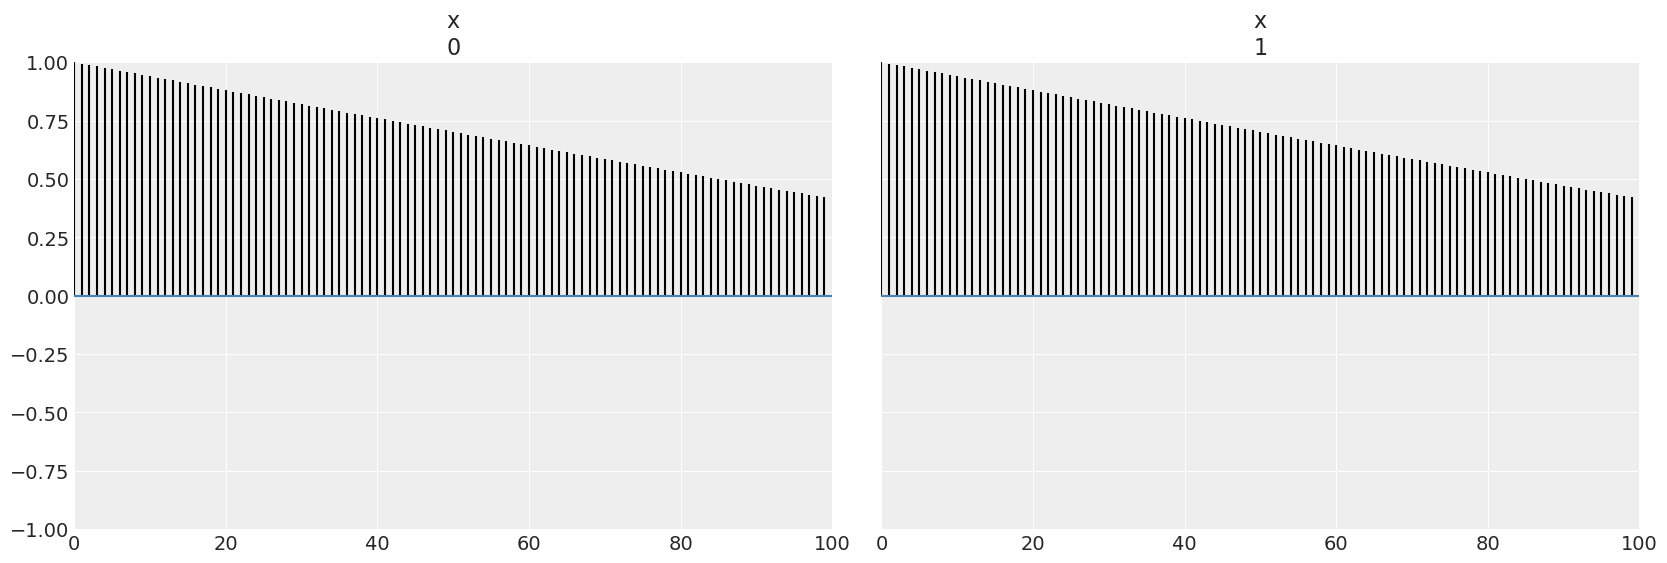

In [6]:
bad_chains = np.linspace(0, 1, 1000).reshape(2, -1)
az.plot_autocorr(bad_chains);

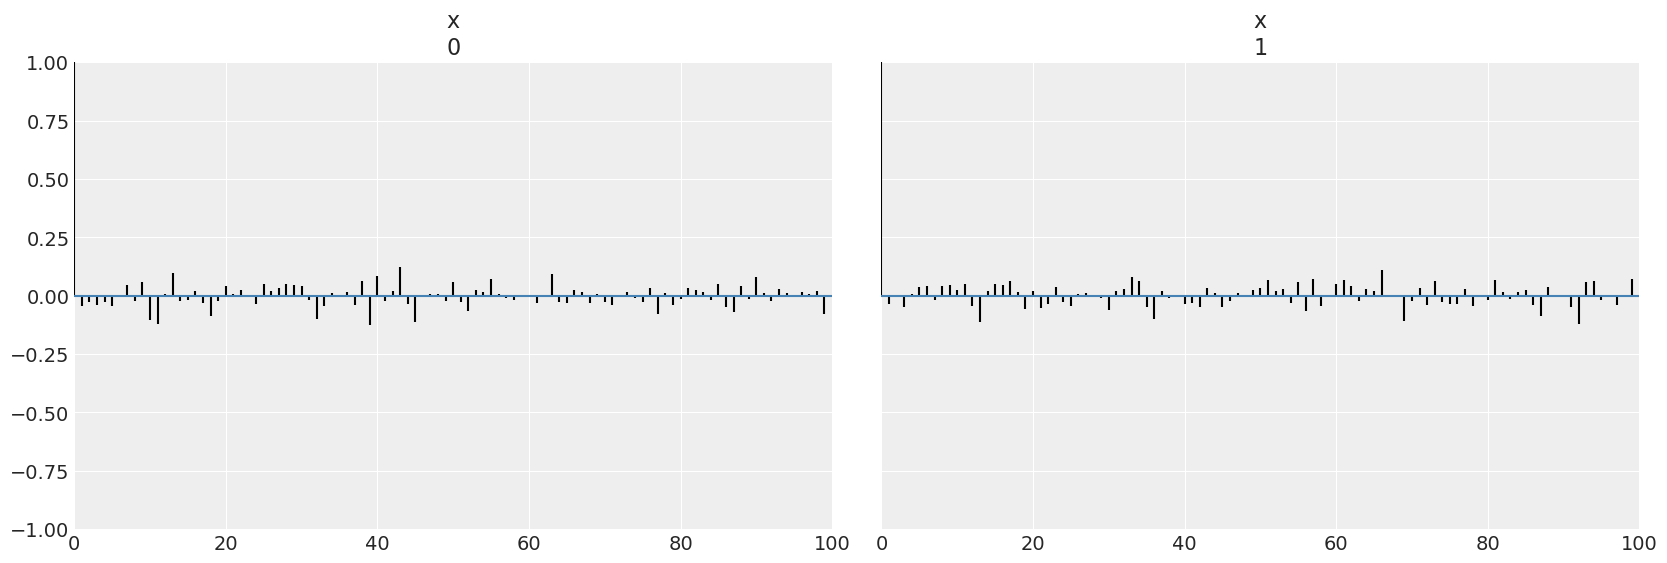

In [7]:
good_chains = stats.uniform.rvs(0, 1,size=(2,500))
az.plot_autocorr(good_chains);

## How to fix it

* More samples (this becomes less and less practicall as the autocorrelation increases)
* Reparametrize the model
* Follow PyMC3 warning messages and suggestions!

## Effective Sample Size (ess)

<br>

    az.ess(trace)

* In the sample large enough?

* A sample with autocorrelation has less information than a sample of the same size without autocorrelation. We can use the autocorrelation to estimate which will be the size of a given sample with the equivalent information but without autocorrelation and this is call the effective sample size. The more autocorrelated a parameter is, the larger the number of samples we will need to obtain a given precision, that is autocorrelation has the detrimental effect of effective sample size. 

the ESS of a quantity of interest captures how many independent draws contain the same
amount of information as the dependent sample obtained by the MCMC algorithm.

* We recommend requiring that the rank-normalized ESS is greater than 400


We can compute the effective sample size by calling `az.effective_n`

In [8]:
az.ess(bad_chains), az.ess(good_chains)

(2.284600376742084, 1069.3542215120517)

In [9]:
az.summary(good_chains)

,mean,sd,mcse_mean,mcse_sd,hpd_3%,hpd_97%,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
x,0.502,0.285,0.009,0.006,0.037,0.965,1081.0,1073.0,1069.0,834.0,1.0


## $\hat R$ (aka R hat)

* Did the chains mix well?

* Compares the _between chain_ variance with the _in chain_ variance .

* If all the chains have converged, the variance should be similar across all chains, and the pooled sample of all chains.

* Ideally it should be 1, numbers lower than 1.05 are generally considered OK. 

* It can be interpreted as the overestimation of variance due to MCMC finite sampling. If you continue sampling infinitely you should get a reduction of the variance of your estimation by a $\hat R$ factor.


# mcse error 

One of the quantities returned by summary is the mc_error. This is an estimation of the error introduced by the sampling method. The estimation takes into account that the samples are not truly independent of each other. If the standard error of the means X of n blocks, each block is just a portion of the trace

This error should be below the precision we want in our results

## Rank plot

<br>

    az.plot_rank()


* Rank plots are histograms of the ranked posterior draws (ranked over all chains) plotted separately for each chain.

* If all of the chains are targeting the same posterior, we expect the ranks in each chain to be uniform

* If rank plots of all chains look similar, this indicates good mixing of the chains


* Basically deviations from uniformity are signaling a chain that is not sampling all the regions properly


* This is a recently proposed visual test, author argue superiority over trace plots.



[Aki Vehtari et al](https://arxiv.org/abs/1903.08008)

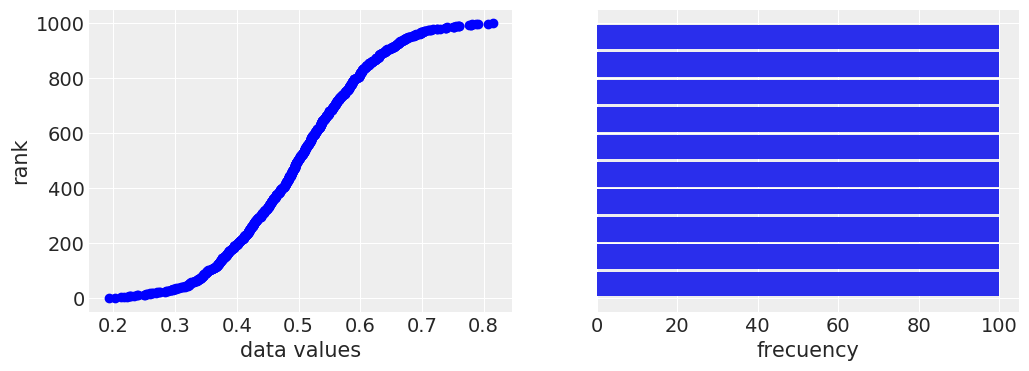

In [10]:
original_data = np.random.beta(10, 10, 1000)
ranked_data = stats.rankdata(original_data)

_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].plot(original_data, ranked_data, 'bo')
ax[0].set_xlabel('data values')
ax[0].set_ylabel('rank')
ax[1].hist(ranked_data, rwidth=0.9, orientation='horizontal');
ax[1].set_xlabel('frecuency');

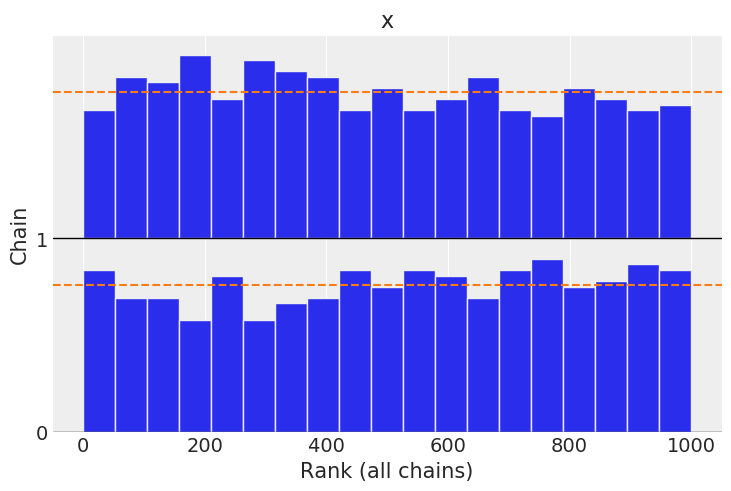

In [11]:
az.plot_rank(good_chains);

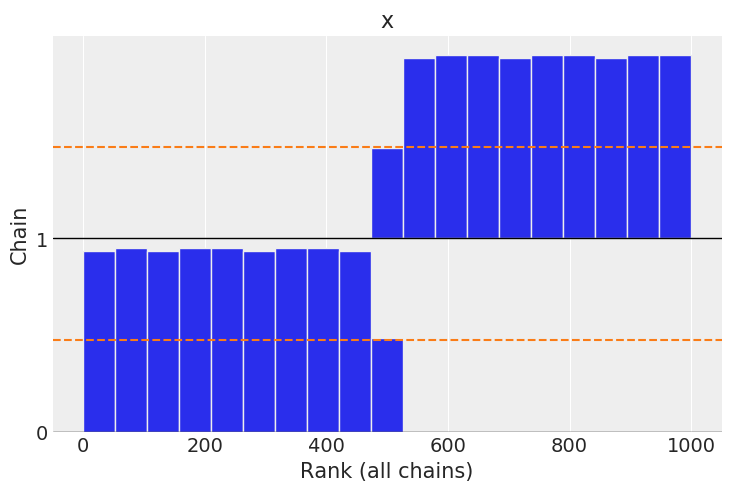

In [12]:
az.plot_rank(bad_chains);

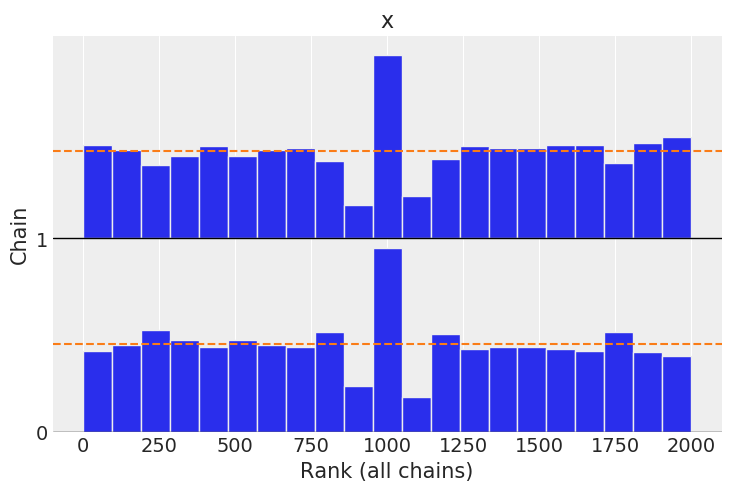

In [13]:
dada = np.random.normal(0, 1, (2, 1000))
dada[:,0:100] = 0
az.plot_rank(dada);

# Hands-on

Run the following models and diagnose the samples

In [14]:
with pm.Model() as good_model:
    μ = pm.Normal('μ', 0, 1000, shape=2)
    y = pm.Poisson('y', np.exp(μ), observed=[1, 10])
    good_samples = pm.sample(1000)
    
with pm.Model() as bad_model:
    # Priors
    μ = pm.Normal('μ', 0, 1000, shape=2)
    #likelihood
    y = pm.Poisson('y', np.exp(μ[0] + μ[1]), observed=[1])
    bad_samples = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2402.20draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [μ]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:49<00:00, 60.81draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


## Diagnosing gradient-based algorithms

<br>


* Algorithms like NUTS due to their inner workings offer some specific tails not available from non-gradient MCMC methods


* Generally this are very sensitive tests

In [15]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    trace_cm = pm.sample(2000, random_seed=7)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    bof = pm.Normal('bof', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + bof * a)
    trace_ncm = pm.sample(2000, random_seed=7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1069.04draws/s]
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.537087638612188, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bof, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:03<00:00, 1581.59draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Energy transition vs marginal energy

<br>

* If the energy transition distribution is similar to the marginal energy distribution then we will generate nearly-independent samples from the marginal energy distribution at every transition


* We can think of a Hamiltonian MonteCarlo as a two step process
    * A deterministic sampling (following the Hamiltonian)
    * A random walk over the momentum space

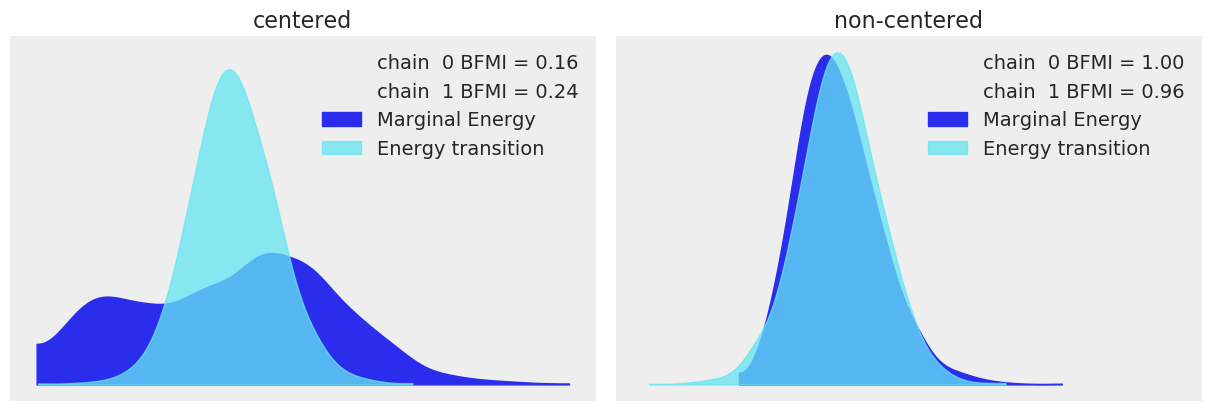

In [16]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 4), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_energy(tr, ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

### Divergences


* One benefit of gradient based samplers is that they fail with style

* When the exact trajectories lie regions of high curvature, the numerical trajectories can diverge

* divergent numerical trajectories are extremely sensitive identifiers of _pathological neighborhoods_ and hence provide a powerful and immediate diagnostic

* Divergences can be identified


[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)

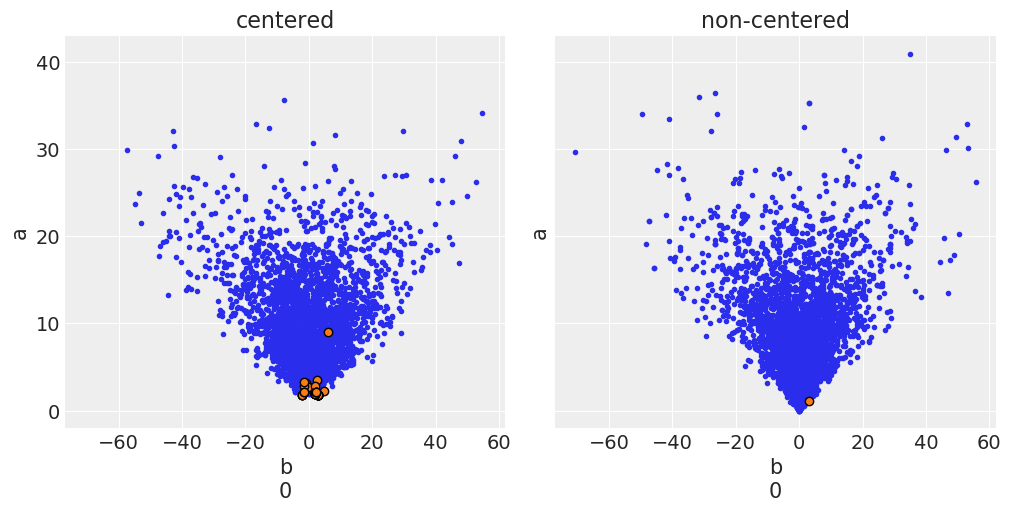

In [17]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, contour=False, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])

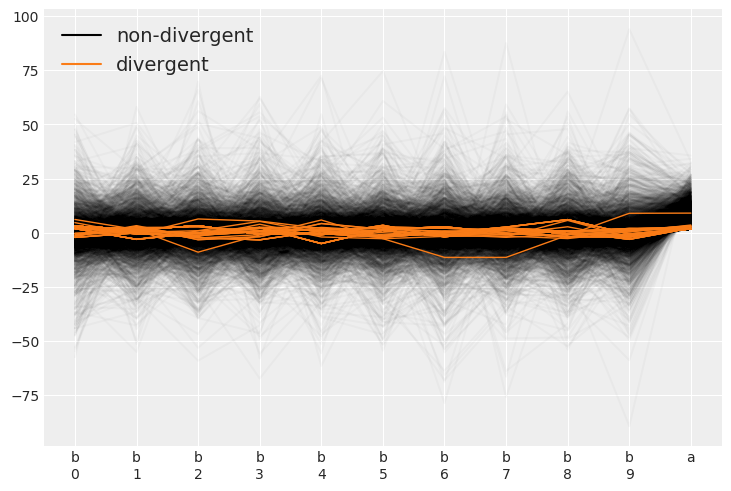

In [18]:
az.plot_parallel(trace_cm);

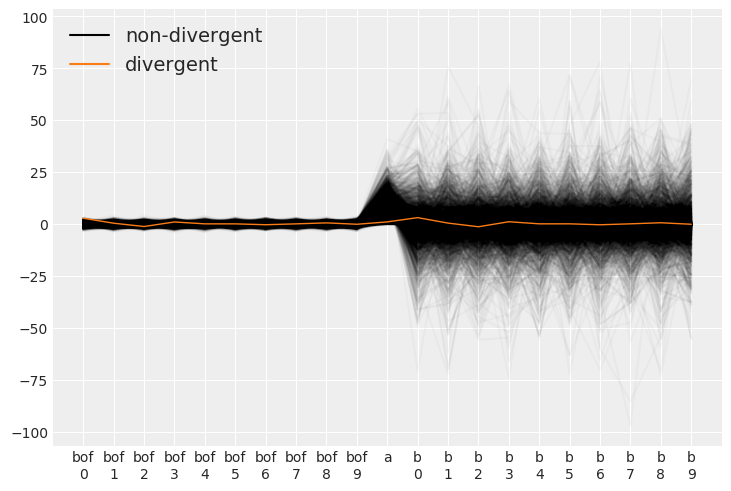

In [19]:
az.plot_parallel(trace_ncm);

## How to fix divergences


* When the pathologies are sufficiently mild, the divergences can be eliminated by increasing the desired acceptance rate (`target_accept`) this is done internally 
by using a smaller step size 

* When the pathologies are too severe other measures are needed, including: 
    * Using stronger priors
    * Reparametrization of the model

# A Bayesian workflow

<center><img src="img/Bayesian_workflow.png" width=900></center>

Data can be _real_ data or simulated data from the prior predictive distribution (in that case we check we are able to recover the known parameters).
    
Adapted from [Eric Novik](https://twitter.com/ericnovik) that is adapted from the [Stan team](https://mc-stan.org/), who in turn have seen further by standing on the shoulders of Giants.

## Simulation-Based Calibration


*

*

* 